In [1]:
import sys
sys.path.insert(1, '/Users/mac/Desktop/PycharmProjects/TAADL/src')
sys.path.insert(2, '/Users/mac/Desktop/PycharmProjects/TAADL/models')

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from strategy import RiskParity
from utils import load_data, train_test_split
from torch.utils.data import Dataset, DataLoader

# Data Preprocessing

In [3]:
# load and preprocess the data
prices_d, prices_m = load_data()
Z_tr, Z_te, X_tr, X_te, cdf = train_test_split(prices_m)

In [9]:
from scipy.optimize import minimize, Bounds, LinearConstraint


class RiskParity:
    def __init__(self, data:pd.DataFrame, bound:list = [0, np.inf]):
        self.data = {}
        self.data["price"] = data
        self.data["lret"]  = np.log(data/data.shift(1)).fillna(0)
        self.data["rv"]    = self.data["lret"].add(1)
        self.num_assets = self.data["price"].shape[1]

        # portoflio weight and performance dataframes which are to be filled.
        self.allocation   = pd.DataFrame(index=self.data["price"].index, columns=self.data["price"].columns)
        self.equity_curve = pd.DataFrame(index=self.data["price"].index, columns=['Risk_Parity']) # cumulative return
        
        # Optimization constraints
        self.bounds = Bounds([bound[0]]*self.num_assets, [bound[1]]*self.num_assets)  # 모든 weight 의 lower limit 부여. Default: 0 <= x
        self.constraint = LinearConstraint([[1]*self.num_assets], [1], [1])  # 모든 weight 의 합은 1 이라는 조건 부여
  
    def obj_func(self, w: np.ndarray, cov: np.ndarray, b:np.ndarray):
        sigma = np.sqrt(w.T @ cov @ w)
        x = w/sigma
        return np.sum(abs((cov @ x) * x - b))
        
    def calc_weight(self, cov: np.ndarray) -> np.array:
        # define initial weight to optimize
        b = np.repeat([1/self.num_assets], self.num_assets) # 1/N
        init_w = np.array([1/self.num_assets] * self.num_assets)
        result = minimize(fun=self.obj_func, method='SLSQP', x0=init_w, args=(cov, b), bounds=self.bounds, constraints=self.constraint, options ={'ftol':1e-8}) # minimize port. variance
        return result['x'] #normalize the weight

    def run(self):
        """
        note that this strategy performs rebalancing once per month. (end of the month.)
        Hence we select monthly frequency.
        """
        # calculate portfolio weight first.
        lret = self.data['lret']
        months = pd.unique(lret.index.strftime('%Y-%m')) # a list containing values as 'yyyy-mm' format e.g '2019-01'

        for idx in range(1,len(months)):
            last_month = months[idx-1] 
            this_month = months[idx]

            # using the daily return data of the last month, update weight this month
            cov = lret.loc[last_month,:].cov().values
            weight = self.calc_weight(cov)
            self.allocation.loc[this_month,:] = weight.T
        
    def performance(self):
        """
        run 메서드를 통해 계산한 weight 를 이용하여 포트폴리오의 성과를 계산합니다.
        """
        self.equity_curve = pd.DataFrame(index=self.data["price"].index, columns=['cumulative_return']) # cumulative return
        rv = self.data['rv'] 
        months = pd.unique(rv.index.strftime('%Y-%m')) # a list containing values as 'yyyy-mm' format e.g '2019-01'
        
        aum = 1 # for each month, we calculate daily return
        for idx in range(1,len(months)): 
            this_month = months[idx]
            self.equity_curve.loc[this_month,:] = (rv.loc[this_month,:].cumprod(axis = 0) @ self.allocation.loc[this_month,:].iloc[-1:].T).values * aum
            aum = self.equity_curve.loc[this_month,:].iloc[-1].values # update aum as the latest value of this month.

        df_profit_history = self.equity_curve
        df_profit_history = (df_profit_history / (df_profit_history.shift().fillna(1)))-1
        df_mean = df_profit_history.rolling(252).mean() * 252
        df_std = df_profit_history.rolling(252).std() * np.sqrt(252)
        self.annual_sharpe = (df_mean)/(df_std)

In [10]:
df = pd.DataFrame()

print('normal Risk Parity')
rp = RiskParity(prices_d)
rp.run()
rp.performance()
df['RP_normal'] = rp.equity_curve
alloc_normal = rp.allocation


normal Risk Parity


<AxesSubplot:xlabel='Date'>

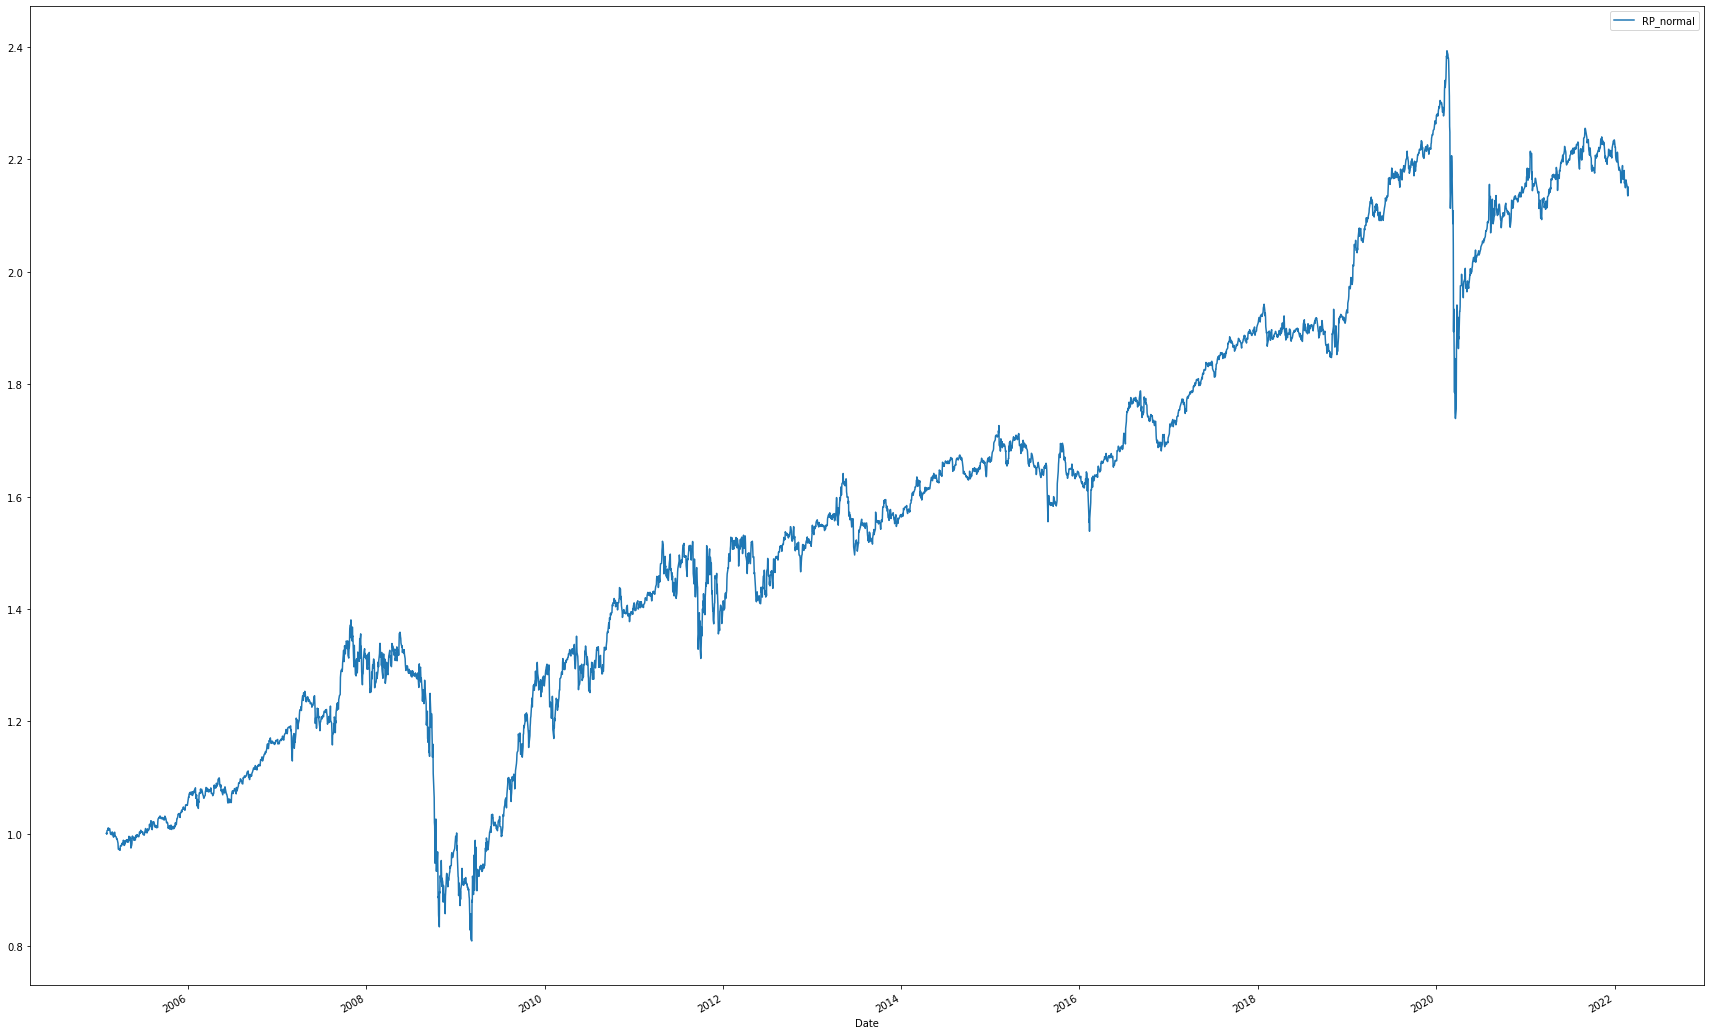

In [11]:
df.plot(figsize=(30,20))

In [5]:
def calc_rc(cov, w):
    rc = (cov @ w) * w
    var = w.T @ cov @ w
    return rc/var